# Ideas

* Backtesting: don't cross the spread, place limit orders in anticipation of a big price move
* Consider different time horizons via logsigs / conv layers with different kernels?
* Large spread should be a huge indicator. Also don't give up spread easily if it's huge
* Avoid very short holding peridos (smoothing, impact ideas)
* If short, don't sell on neutral signal, sell first on opposite signal (if nothing lost yet)
* Place limit orders: what is our anticipation? Expect large drop and rebound (and vice versa)?
* Which portion of the portfolio (Kelly, fixed proportion of your wealth)?
* Better smoothing of the strategy

# AB Test

* Ordering of the features: (ap, av, bp, bv) vs. (ap, bp, av, bv)

# To-Dos

* Never re-index / reset index: create method integrate that takes strategy and asset price paths and calculates pnl
* Proper scaling and transforms

In [1]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

In [2]:
# size of the time-series slice used as input to the NN
WINDOW_SIZE = 100

# offset for the rolling windows used for training
OFFSET = 10

# size of the smoothing kernel used to generate labels
KERNEL_SIZE = 50

# center of mass for smoothing the strategy
COM = 10

# labels are quantized into -1, 0, 1 based on this threshold
LABEL_THRESHOLD = 1e-5

In [4]:
apcs = [f'ap_{i}' for i in range(10)]
avcs = [f'av_{i}' for i in range(10)]
bpcs = [f'bp_{i}' for i in range(10)]
bvcs = [f'bv_{i}' for i in range(10)]

keys = [x for items in zip(apcs, bpcs, avcs, bvcs) for x in items]
features = ['timestamp_diff', 'bid_diff_feature_1', 'ask_diff_feature_1', 'spread']

# Data

In [5]:
pd.set_option('max_rows', 100)

In [6]:
df = pd.read_csv('_input/data.csv')[:20000]
df

,timestamp,best_bid_price,best_ask_price,estimated_delivery_price,index_price,mark_price,open_interest,settlement_price,change_id,ap_0,...,bp_7,bv_7,ap_8,av_8,bp_8,bv_8,ap_9,av_9,bp_9,bv_9
0,1626127132362,32870.0,32870.5,32883.12,32883.12,32873.38,340919370,34285.44,32936741408,32870.5,...,32861.5,81780.0,32879.5,190510.0,32860.0,1300.0,32880.0,2800.0,32859.0,4290.0
1,1626127132619,32870.0,32870.5,32883.12,32883.12,32873.40,340919370,34285.44,32936741424,32870.5,...,32861.5,81780.0,32880.0,2800.0,32860.0,1300.0,32880.5,93240.0,32859.0,4290.0
2,1626127132720,32870.0,32870.5,32883.12,32883.12,32873.40,340919370,34285.44,32936741472,32870.5,...,32861.5,81780.0,32880.0,2800.0,32860.0,1300.0,32880.5,93200.0,32859.0,4290.0
3,1626127132931,32870.0,32870.5,32883.56,32883.56,32873.84,340919370,34285.44,32936741508,32870.5,...,32861.5,81780.0,32880.0,2800.0,32860.0,1300.0,32880.5,108040.0,32859.0,4290.0
4,1626127133031,32870.0,32870.5,32883.56,32883.56,32873.84,340919370,34285.44,32936741550,32870.5,...,32861.5,81780.0,32879.5,190420.0,32860.0,1300.0,32880.0,2800.0,32859.0,4290.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1626130101676,33045.5,33046.0,33055.07,33055.07,33047.39,342882300,34285.44,32937625906,33046.0,...,33040.0,72360.0,33054.5,100.0,33039.0,90.0,33055.0,100.0,33038.0,5000.0
19996,1626130102009,33045.5,33046.0,33055.07,33055.07,33047.42,342882300,34285.44,32937625930,33046.0,...,33040.0,72360.0,33054.5,100.0,33039.0,90.0,33055.0,100.0,33038.0,5000.0
19997,1626130102111,33045.5,33046.0,33055.07,33055.07,33047.42,342882300,34285.44,32937625966,33046.0,...,33039.0,90.0,33055.0,100.0,33038.0,2000.0,33055.5,21200.0,33036.5,63200.0
19998,1626130102450,33045.5,33046.0,33055.07,33055.07,33047.42,342882300,34285.44,32937625997,33046.0,...,33039.0,90.0,33055.0,100.0,33038.0,2000.0,33055.5,21200.0,33037.0,10120.0


In [7]:
def prepare_df(df, k=KERNEL_SIZE):

    # diff time and asset price with lag=1 to remove trend
    df0 = df[['timestamp', 'best_bid_price', 'best_ask_price']].diff(1).rename(columns={'timestamp': 'timestamp_diff', 'best_bid_price': f'bid_diff_feature_1', 'best_ask_price': f'ask_diff_feature_1'})
    df0['timestamp_diff'] /= 1000.

    df1 = df[['best_bid_price', 'best_ask_price'] + keys]
    dfX = pd.concat([df1, df0], axis=1)

    # set prices as relative differences
    dfX[apcs] = dfX[apcs].sub(dfX['ap_0'], axis=0)
    dfX[bpcs] = -dfX[bpcs].sub(dfX['bp_0'], axis=0)

    # remove nans
    dfX = dfX[~dfX.isna().any(axis=1)]

    # rescale volumes
    l = 10.
    u = 1000000.
    dfX[avcs + bvcs] = (dfX[avcs + bvcs] - l) / (u - l)
    
    dfX['mid_price'] = (dfX['best_bid_price'] + dfX['best_ask_price']) / 2
    dfX['spread'] = dfX['best_ask_price'] - dfX['best_bid_price']

    # https://arxiv.org/pdf/1808.03668.pdf, p. 4
    dfX['m+'] = dfX['mid_price'].shift(-(k-1)).rolling(k).mean()
    dfX['m-'] = dfX['mid_price'].rolling(k).mean()
    dfX['y1'] = (dfX['m+'] - dfX['mid_price']) / dfX['mid_price']
    dfX['y2'] = (dfX['m+'] - dfX['m-']) / dfX['m-']

    dfX = dfX.iloc[k-1:-(k-1)]

    # reset index
    return dfX

dfX = prepare_df(df)
dfX[:100]

,best_bid_price,best_ask_price,ap_0,bp_0,av_0,bv_0,ap_1,bp_1,av_1,bv_1,...,bv_9,timestamp_diff,bid_diff_feature_1,ask_diff_feature_1,mid_price,spread,m+,m-,y1,y2
50,32874.0,32874.5,0.0,-0.0,0.007350,0.01316,2.0,4.0,0.00219,0.04642,...,0.003360,0.060,0.0,0.0,32874.25,0.5,32872.25,32873.21,-0.000061,-0.000029
51,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,4.0,0.00219,0.04642,...,0.003360,0.228,0.0,0.0,32874.25,0.5,32872.17,32873.29,-0.000063,-0.000034
52,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,4.0,0.00219,0.04642,...,0.003360,0.080,0.0,0.0,32874.25,0.5,32872.09,32873.37,-0.000066,-0.000039
53,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,4.0,0.00219,0.04642,...,0.003360,0.126,0.0,0.0,32874.25,0.5,32872.01,32873.45,-0.000068,-0.000044
54,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,4.0,0.00219,0.04642,...,0.002590,0.051,0.0,0.0,32874.25,0.5,32871.93,32873.53,-0.000071,-0.000049
55,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,4.0,0.00219,0.04642,...,0.001190,0.168,0.0,0.0,32874.25,0.5,32871.85,32873.61,-0.000073,-0.000054
56,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,4.0,0.00219,0.04642,...,0.015050,0.094,0.0,0.0,32874.25,0.5,32871.77,32873.69,-0.000075,-0.000058
57,32874.0,32874.5,0.0,-0.0,0.002150,0.01316,2.0,3.5,0.00219,0.00099,...,0.015050,0.253,0.0,0.0,32874.25,0.5,32871.69,32873.77,-0.000078,-0.000063
58,32874.0,32874.5,0.0,-0.0,0.002150,0.03126,2.0,3.5,0.00219,0.00099,...,0.015050,0.201,0.0,0.0,32874.25,0.5,32871.61,32873.85,-0.000080,-0.000068
59,32874.0,32874.5,0.0,-0.0,0.002150,0.03126,2.0,3.5,0.00219,0.00099,...,0.015050,0.548,0.0,0.0,32874.25,0.5,32871.53,32873.93,-0.000083,-0.000073


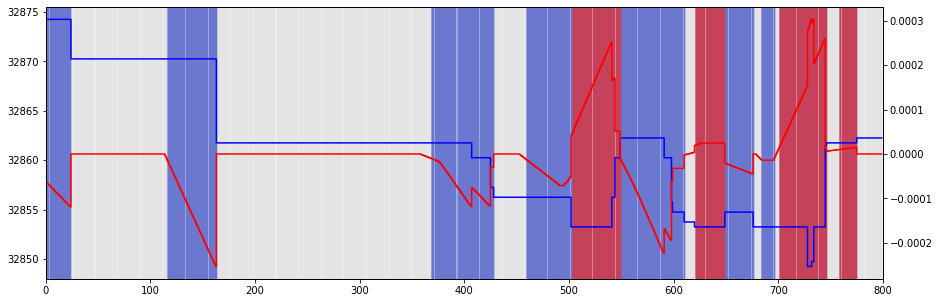

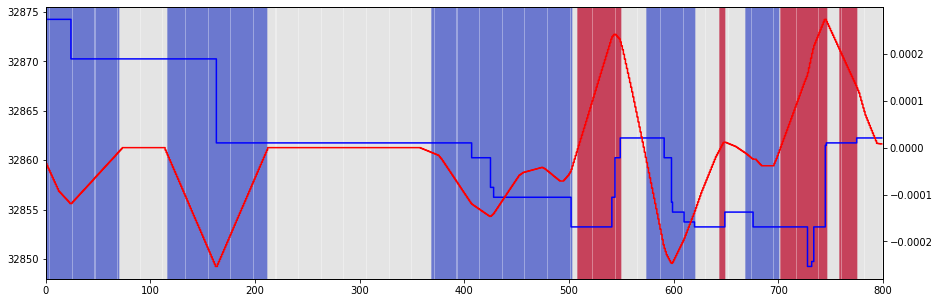

In [8]:
N0, N1 = 0, 800

for label in 'y1', 'y2':

    plt.figure(figsize=(15, 5))

    # colors
    cs = -1 + 1. * (dfX.iloc[N0:N1][label] > -LABEL_THRESHOLD) + 1. * (dfX.iloc[N0:N1]['y1'] > LABEL_THRESHOLD)
    cs = cs.to_numpy().reshape(1, -1)
    plt.pcolor(cs, cmap='coolwarm', alpha=0.5, linewidths=0)
    plt.yticks([])
    
    # price
    plt.twinx().step(np.arange(N1-N0), dfX.iloc[N0:N1]['mid_price'], c='b')

    # label
    plt.twinx().step(np.arange(N1-N0), dfX.iloc[N0:N1][label], c='r')


In [26]:
def split(df, offset, window_size):
    
    threshold = 5e-5
    
    # X1
    X1 = np.array([df.iloc[i*offset:i*offset+window_size][keys] for i in range((len(df) - window_size) // offset)])
    X1 = X1[:, :, :, np.newaxis]
    
    # X2
    X2 = np.array([df.iloc[i*offset:i*offset+window_size][features] for i in range((len(df) - window_size) // offset)])
    
    # y
    y = dfX.iloc[offset-1+window_size:len(df):offset]['y2'].to_numpy()
    y = -1 + 1. * (y >= -threshold) + 1. * (y >= threshold)
    
    # one-hot encoder
    enc = OneHotEncoder(sparse=False)
    y = enc.fit_transform(y.reshape(-1, 1))

    return X1, X2, y

(array([616.,   0.,   0.,   0.,   0., 643.,   0.,   0.,   0., 721.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

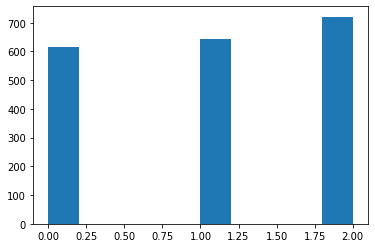

In [27]:
X1, X2, y = split(dfX, OFFSET, WINDOW_SIZE)
plt.hist(np.argmax(1+y, axis=1))

In [28]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=0.15)

# Build model

In [29]:
def build_model(window_size):

    input_layer1 = Input(shape=(window_size, 40, 1))
    input_layer2 = Input(shape=(window_size, len(features)))

    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(input_layer1)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(16, kernel_size=(1, 2), strides=(1, 2), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    
    x = Conv2D(16, kernel_size=(1, 10), activation='relu')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)
    x = Conv2D(16, kernel_size=(4, 1), activation='relu', padding='same')(x)

    x = Reshape((window_size, -1))(x)

    x = concatenate([x, input_layer2])

    lstm_layer = LSTM(64)(x)
    bn_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.8)(bn_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model([input_layer1, input_layer2], output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy')

    return model


In [30]:
model = build_model(window_size=WINDOW_SIZE)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 40, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 100, 20, 16)  48          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 100, 20, 16)  1040        conv2d_10[0][0]                  
____________________________________________________________________________________________

In [32]:
cp_callback = ModelCheckpoint(filepath='_output/model.h5', save_weights_only=True, save_best_only=True)
history = model.fit([X1_train, X2_train], y_train, epochs=30, validation_split=0.15, callbacks=[cp_callback], verbose=2)

Epoch 1/30
45/45 - 11s - loss: 1.4345 - val_loss: 1.0659
Epoch 2/30
45/45 - 6s - loss: 1.3047 - val_loss: 1.0638
Epoch 3/30
45/45 - 6s - loss: 1.2241 - val_loss: 1.0565
Epoch 4/30
45/45 - 5s - loss: 1.1662 - val_loss: 1.0493
Epoch 5/30
45/45 - 6s - loss: 1.1562 - val_loss: 1.0368
Epoch 6/30
45/45 - 6s - loss: 1.1109 - val_loss: 1.0221
Epoch 7/30
45/45 - 6s - loss: 1.1189 - val_loss: 1.0243
Epoch 8/30
45/45 - 6s - loss: 1.0482 - val_loss: 0.9915
Epoch 9/30
45/45 - 6s - loss: 1.0449 - val_loss: 0.9962
Epoch 10/30
45/45 - 6s - loss: 1.0086 - val_loss: 0.9467
Epoch 11/30
45/45 - 5s - loss: 0.9935 - val_loss: 1.0247
Epoch 12/30
45/45 - 6s - loss: 0.9818 - val_loss: 0.9300
Epoch 13/30
45/45 - 6s - loss: 0.9440 - val_loss: 0.9847
Epoch 14/30
45/45 - 5s - loss: 0.9698 - val_loss: 0.8929
Epoch 15/30
45/45 - 5s - loss: 0.9658 - val_loss: 1.4900
Epoch 16/30
45/45 - 5s - loss: 0.9342 - val_loss: 1.0980
Epoch 17/30
45/45 - 5s - loss: 0.9329 - val_loss: 0.9808
Epoch 18/30
45/45 - 5s - loss: 0.9275 -

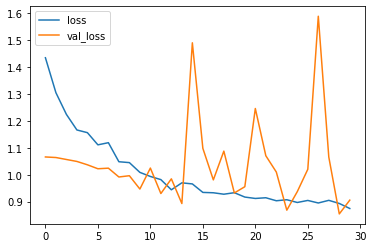

In [33]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [34]:
model.evaluate([X1_test, X2_test], y_test)

10/10 [==============================] - 0s 30ms/step - loss: 1.0443


1.0442664623260498

In [35]:
model.load_weights('_output/model.h5')
model.evaluate([X1_test, X2_test], y_test)

10/10 [==============================] - 0s 31ms/step - loss: 0.9153


0.9153243899345398

# Backtest

In [ ]:
def create_strategy(df):
    
    # load backtest dataset
    dfY = prepare_df(df)

    # predict returns
    X1, X2, _ = split(dfY, 1, WINDOW_SIZE)
    ret_pred = model.predict([X1, X2])
    strategy = np.argmax(ret_pred, axis=1) - 1.

    # calculating ewm strategy
    retval_df = dfY[['timestamp_diff', 'best_bid_price', 'best_ask_price', 'y2']].copy()
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'strategy'] = strategy.reshape(-1)
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'ewm_strategy_10'] = np.round(retval_df['strategy'].ewm(com=COM).mean())

    return retval_df

In [ ]:
dff = create_strategy(pd.read_csv('_input/data.csv')[30000:35000])
#dff.style.background_gradient(cmap='coolwarm', subset=(dff.index, ['y2', 'strategy', 'ewm_strategy_10']))

In [211]:
df[::1000].diff()

,timestamp,best_bid_price,best_ask_price,estimated_delivery_price,index_price,mark_price,open_interest,settlement_price,change_id,ap_0,...,bp_7,bv_7,ap_8,av_8,bp_8,bv_8,ap_9,av_9,bp_9,bv_9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,154422.0,9.5,9.5,4.39,4.39,3.37,6350.0,0.0,36924.0,9.5,...,6.5,-78630.0,7.5,-173400.0,7.0,130.0,7.5,43590.0,7.5,67850.0
2000,163958.0,18.0,18.0,20.62,20.62,21.33,28360.0,0.0,42925.0,18.0,...,21.5,-1950.0,18.5,-15110.0,22.0,1570.0,18.5,-28480.0,21.5,-59390.0
3000,135389.0,47.0,47.0,50.14,50.14,48.07,224800.0,0.0,63879.0,47.0,...,48.0,17790.0,49.5,-1900.0,47.5,7000.0,50.0,-17110.0,47.5,3020.0
4000,137019.0,-20.5,-20.5,-14.76,-14.76,-18.67,-4750.0,0.0,45505.0,-20.5,...,-20.0,-1220.0,-17.5,15910.0,-19.5,-3000.0,-18.0,21150.0,-19.5,-10770.0
5000,150824.0,26.0,26.0,18.66,18.66,23.85,14760.0,0.0,45795.0,26.0,...,27.5,-16770.0,22.0,-15510.0,27.5,9710.0,23.0,-5870.0,28.0,-4100.0
6000,139062.0,109.0,109.0,110.47,110.47,116.43,285070.0,0.0,49202.0,109.0,...,98.0,41060.0,113.5,1930.0,98.0,65610.0,112.5,49430.0,98.0,-340.0
7000,124196.0,-99.0,-99.0,-93.55,-93.55,-105.77,363260.0,0.0,77133.0,-99.0,...,-88.5,-9110.0,-99.0,-2410.0,-88.5,-70480.0,-99.0,-43310.0,-89.0,440.0
8000,133391.0,-3.5,-3.5,-9.29,-9.29,-5.01,75740.0,0.0,42108.0,-3.5,...,-4.5,-22950.0,-8.0,24980.0,-4.5,-5520.0,-8.0,59950.0,-4.0,12790.0
9000,147054.0,27.5,27.5,28.22,28.22,25.57,360370.0,0.0,32979.0,27.5,...,27.0,790.0,24.5,-19050.0,27.0,14530.0,24.5,-68560.0,27.0,1760.0


In [ ]:
df = pd.read_csv('_input/data.csv')
pnls = []

for i in tqdm(range(17)):
    dff = create_strategy(df[20000+i*1000:20000+(i+1)*1000])
    int_df = integrate(dff, 'ewm_strategy_10')
    pnls += [int_df.iloc[-1]['pnl']]
    
plt.hist(pnls)
print(np.mean(pnls), np.std(pnls))

# edge
p = np.mean(pnls)
print(p)

  6%|▌         | 1/17 [00:02<00:41,  2.62s/it]

<AxesSubplot:>

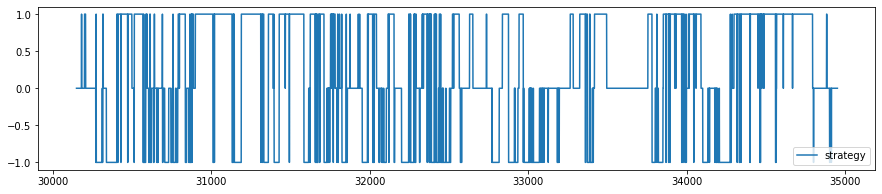

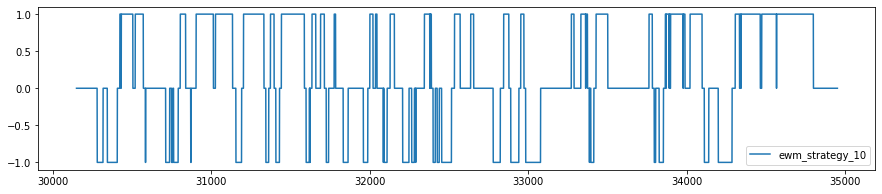

In [186]:
dff[['strategy']].plot(figsize=(15, 3))
dff[['ewm_strategy_10']].plot(figsize=(15, 3))

<AxesSubplot:>

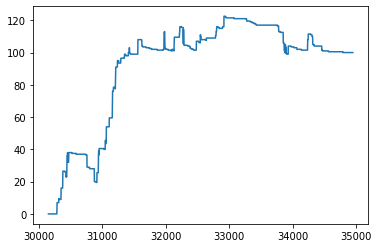

In [187]:
def integrate(df, strategy_column, bid_column='best_bid_price', ask_column='best_ask_price'):

    money = df[bid_column] * np.maximum(dff[strategy_column].fillna(0).diff(-1).shift(1), 0)
    money += df[ask_column] * np.minimum(dff[strategy_column].fillna(0).diff(-1).shift(1), 0)
    pnl = np.cumsum(money) + df[strategy_column] * df[bid_column]
    
    retval_df = df[[bid_column, ask_column, strategy_column]].copy().rename(columns={bid_column: 'bid', ask_column: 'ask', strategy_column: 'strategy'})
    retval_df['money'] = money
    retval_df['pnl'] = pnl
    
    return retval_df

int_df = integrate(dff, 'ewm_strategy_10')
int_df['pnl'].plot()